In [1]:
#!/usr/bin/env python`
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print(fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 256
TEST_SIZE = 0.2


# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [49]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [50]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [8]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
#data_df.head()

In [9]:
for col in data_df.columns :
    print(f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [10]:
data_df['Position'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
18202    False
18203    False
18204    False
18205    False
18206    False
Name: Position, Length: 18147, dtype: bool

In [11]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [12]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [13]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [14]:
data_df = data_df[rel_cols]
#data_df.head()

In [15]:
labels101 = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [16]:
features_df = data_df.drop('Position', axis = 1)
labels = data_df['Position']

In [17]:
data_df['Position'].isnull().sum()

0

In [18]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels,
                                     stratify=labels,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [19]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

## Converting to Datasets

In [21]:
#to keep tensors data in a dataframe
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

### Preprocessing and Batching

Apply various transformations, such as shuffling and batching, to the dataset:

In [22]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [23]:
## Optimize for performance
#taking data in cache memory because many times memory remains idel

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
#to see the data - take(1)- gives batch 1
#gives number of rows and columns for each batch
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(256, 33) (256,)


## Prepare model

### Functional API

<p style="font-family: Arial; font-size:1.2em;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

In [25]:
inputs = tf.keras.Input(shape=(33,))
    
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs) #input  #dense layer

outputs = tf.keras.layers.Dense(4)(x)   #output

model = tf.keras.Model(inputs=inputs, outputs=outputs)   #input, output passed

In [26]:
predictions = model(features).numpy()
predictions.shape

(256, 4)

In [27]:
predictions[0].sum()

-2.1793194

In [28]:
tf.nn.softmax(predictions).numpy()[0]

array([0.09739886, 0.17486389, 0.1889585 , 0.5387787 ], dtype=float32)

In [29]:
tf.nn.softmax(predictions).numpy().sum(axis = 1)[0]

1.0

In [30]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 18)                612       
                                                                 
 dense_1 (Dense)             (None, 4)                 76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [32]:
loss_fn(labels, predictions).numpy()

1.74544

Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer
- List of metrics to monitor

In [33]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [34]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/100


57/57 [==============================] - 2s 9ms/step - loss: 1.1120 - accuracy: 0.5224 - val_loss: 0.7880 - val_accuracy: 0.7245
Epoch 2/100
57/57 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.7683 - val_loss: 0.5661 - val_accuracy: 0.7871
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.8087 - val_loss: 0.4728 - val_accuracy: 0.8085
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 0.4388 - accuracy: 0.8257 - val_loss: 0.4253 - val_accuracy: 0.8212
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 0.4008 - accuracy: 0.8387 - val_loss: 0.3952 - val_accuracy: 0.8339
Epoch 6/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3758 - accuracy: 0.8465 - val_loss: 0.3742 - val_accuracy: 0.8399
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3584 - accuracy: 0.8538 - val_loss: 0.3593 - val_accuracy: 0.8427
Epoch 8/100

In case we want to separately evaluate this model, we have `evaluate` function.

In [35]:
model.evaluate ( test_ds, verbose=2)

15/15 - 0s - loss: 0.2986 - accuracy: 0.8760 - 51ms/epoch - 3ms/step


[0.2986185550689697, 0.8760330677032471]

In [36]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.112013,0.522422,0.787985,0.724518
1,0.657616,0.768272,0.566133,0.787052
2,0.506772,0.808707,0.472776,0.808540
3,0.438836,0.825722,0.425303,0.821212
4,0.400785,0.838672,0.395163,0.833884


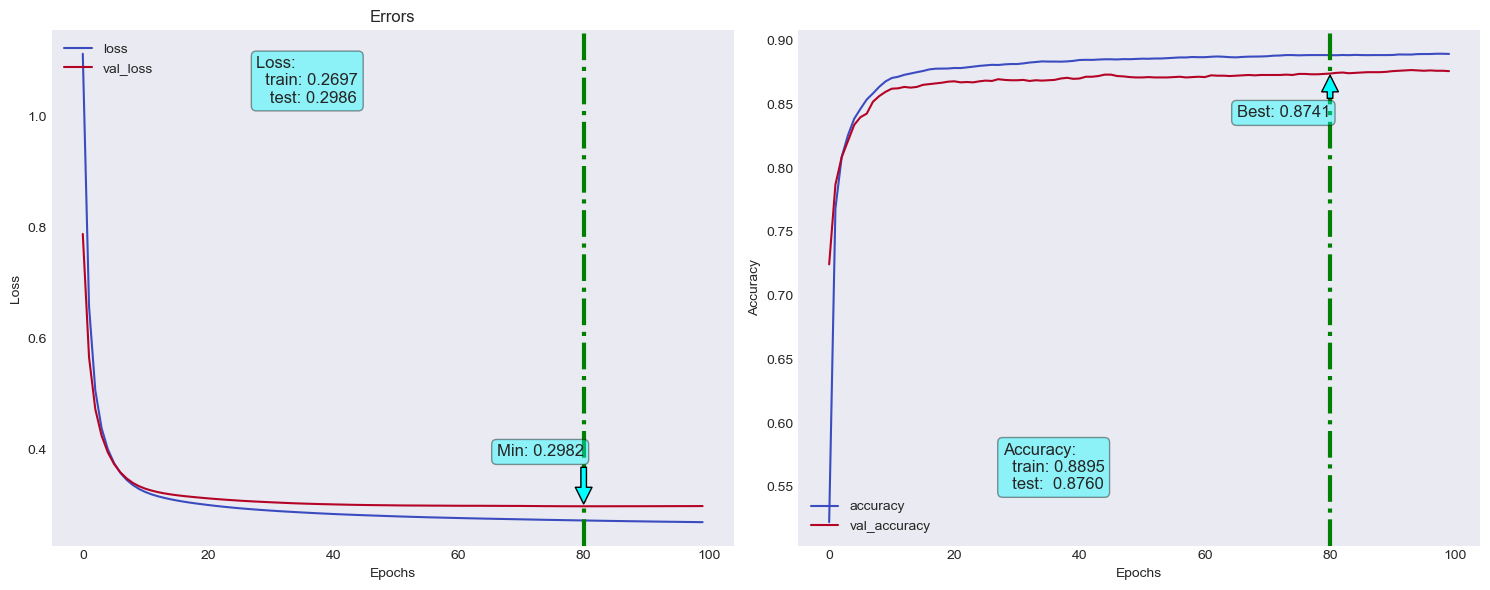

In [37]:
fn_plot_tf_hist(loss_df)

In [38]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
80,0.2727,0.888544,0.298211,0.874105


## Predictions

In [39]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [54]:
#tensors
y_true, pred = [], [] 
for features, labels in train_ds:
    y_pred = probability_model(features).numpy()
    pred.extend(y_pred)
    y_true.extend(labels)
y_pred.shape

(181, 4)

In [42]:
print(classification_report( y_train, y_pred.argmax( axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.93      0.93      4693
           2       0.84      0.87      0.86      5470
           3       0.86      0.78      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [44]:
y_pred = probability_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87603


In [45]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.92      1173
           2       0.82      0.86      0.84      1368
           3       0.83      0.74      0.79       684

    accuracy                           0.88      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



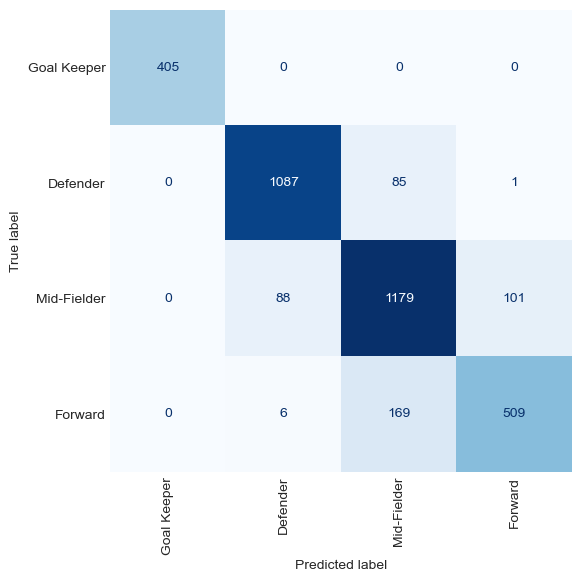

In [46]:
fn_plot_confusion_matrix( y_test, y_pred.argmax( axis = 1), labels=labels101)